In [2]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from scipy import optimize
from scipy.linalg import block_diag

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from statsmodels.tools.numdiff import approx_fprime, approx_hess

from typing import Union, List, Tuple

"""
Own packages
"""
from codelib.visualization.base import correlation_plot, fan_chart
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix
from codelib.statistics.robust_covariance import fitting_error, crem_denoised_corr_mat
from codelib.statistics.robust_covariance import marchencko_pastur_bounds, marchencko_pastur_density


import codelib.portfolio_optimization.risk_metrics as rm

# Exercises - Week 8

## Problem 1:  Sensitivity of risk based portfolios to variance and correlation misspecification

__Note__: This problem is inspired by the article [Ardia, Bolliger, Boudt, Fleury (2017)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2650644) - "The Impact of Covariance Misspecification in Risk-Based Portfolios"

Consider the correlation matrix 

$$
\mathbf{C} = \begin{bmatrix} 1 & \rho_{1,2} & \rho_{1, 3} \\
                             \rho_{1, 2} & 1 & \rho_{2,3} \\
                             \rho_{1,3} & \rho_{2,3} & 1\end{bmatrix}
$$

and the volatilities $\mathbf{v} = [\sigma_1, \sigma_2, \sigma_3]^\top$. Assume that the true values are given by $(\sigma_1, \sigma_2, \sigma_3, \rho_{1,2}, \rho_{1,3}, \rho_{2, 3}) = (0.1, 0.1, 0.2, -0.1, -0.2, 0.7)$. 

We want to see how we can intuitively visualize the effect of parameter misspecification. 

__Question 1__

Consider the inverse volatility portfolio (for the $N$ asset case)

$$
\mathbf{w}_{\text{IV}} = \left[\frac{1 / \sigma_1}{\sum_{i=1}^N 1 / \sigma_i}, ..., \frac{1 / \sigma_N}{\sum_{i=1}^N 1 / \sigma_i} \right]
$$

Find the inverse portfolio for the three asset case described above. 

__Question 2__


Given a long-only constraint, the global minimum variance portfolio is the solution to the optimization problem 

$$
\mathbf{w}_{\text{GMV}} = \underset{\mathbf{w}}{\text{arg min }} \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

subject to the budget constraint, a return target and positivity constriants

$$
\begin{align}
\mathbf{w}^\top \mathbf{1} &= 1 \\
w_i &\geq 0, \; i=1,..., N
\end{align}
$$

Find the minimum variance portfolio for the three asset case described above.

__Question 3__

We want to examine the effect of misspecifying the volatility. Let the volatility of asset three vary between 10\% and 30\%, e.g. 50 different values. For each value calculate  the $L_1$ distance / norm 

$$
\Vert \mathbf{w}_{\text{True}} - \hat{\mathbf{w}} \Vert_1 \equiv \sum_{i=1}^N \vert w_{\text{True}, i} - \hat{w}_i \vert
$$

for both the inverse-volatility and minimum-variance portfolio. Here $\hat{\mathbf{w}}$ indicates the new portfolio weights with the new volatility of assets 3. 

Plot the $L_1$ distance as a function of the volatility of asset three. 

__Quesiton 4__

Now, let the correlation $\rho_{2, 3}$ vary between 0.4 and 1.0. Again, for each value calculate the $L_1$ distance. Plot the $L_1$ distance as a function of $\rho_{2, 3}$


### Solution 

In [3]:
"""
Define inputs
"""

# correlations
corr_mat = np.array([[1.0, -0.1, -0.2],
                     [-0.1, 1.0, 0.7],
                     [-0.2, 0.7, 1.0]])
# volatilities
vols = np.array([0.1, 0.1, 0.2])

# calculate covariance matrix 
cov_mat = corr_to_cov_matrix(corr_mat, vols)

__Question 1__

In [4]:
def calculate_inverse_volatilty(vols: np.ndarray) -> np.ndarray:
    
    """
    Calculate the inverse volatility weights 
    
    Parameters
    ----------
    vols: 
        Volatilites. 
    
    Returns
    -------
    np.ndarray
        Portfolio weights. 
    
    
    """
    
    inv_vols = 1.0 / vols
    sum_inv_vols = np.sum(inv_vols)
    
    w_iv = inv_vols / sum_inv_vols
    
    return w_iv

In [5]:
w_iv = calculate_inverse_volatilty(vols)
w_iv

array([0.4, 0.4, 0.2])

In [6]:
rm.calculate_portfolio_std(w_iv, cov_mat)

0.07797435475847173

__Question 2__

In [7]:
def calculate_min_var_portfolio(cov_mat: np.ndarray, init_weights=None):
    
    """
    Calculate minimum-variance portfolio 
    
    Parameters
    ----------
    cov_mat: 
        Covariance matrix. 
    
    Returns
    -------
    np.ndarray
        Portfolio weights.
    
    """
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # perform optimization
    res = optimize.minimize(lambda x: rm.calculate_portfolio_variance(x, cov_mat) * 100 * 100,
                            init_weights,
                            constraints=[eq_constraint,],
                            bounds=[(0, 1)]*n)
    
    return res.x

In [8]:
w_gmv = calculate_min_var_portfolio(cov_mat)
w_gmv

array([5.00000000e-01, 5.00000000e-01, 8.35439972e-12])

In [9]:
# portfolio std
rm.calculate_portfolio_std(w_gmv, cov_mat)

0.06708203932505598

__Question 3__

In [10]:
std_deviations = np.linspace(0.1, 0.3, 50)

norm_iv_vol = []
norm_gmv_vol = []

for s in std_deviations: 
    
    vols_new = vols.copy()
    vols_new[2] = s
    cov_mat_new = corr_to_cov_matrix(corr_mat, vols_new)
    
    norm_iv_vol.append(np.linalg.norm(calculate_inverse_volatilty(vols_new) - w_iv, ord=1))
    norm_gmv_vol.append(np.linalg.norm(calculate_min_var_portfolio(cov_mat_new) - w_gmv, ord=1))

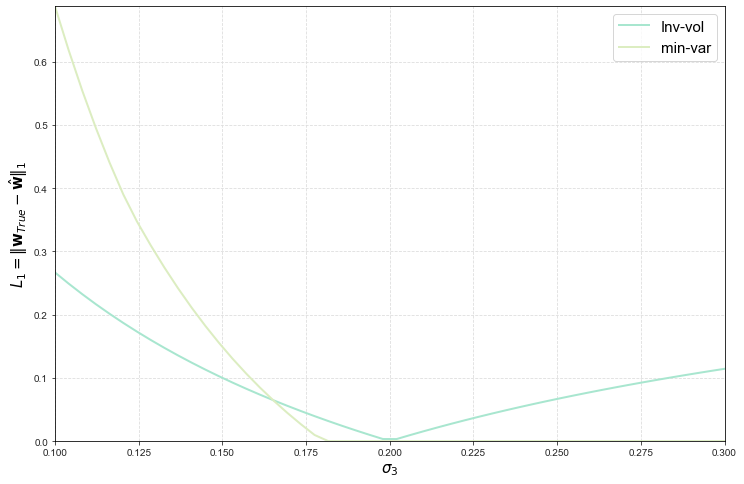

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(std_deviations, norm_iv_vol, label="Inv-vol")
ax.plot(std_deviations, norm_gmv_vol, label="min-var")

ax.set_xlabel("$\\sigma_3$", size=15)
ax.set_ylabel("$L_1 = \\Vert \\mathbf{w}_{True} - \\hat{\\mathbf{w}} \\Vert_1$", size=15)
ax.legend();

Minimum variance does not seem affected by overestimation of $\sigma_3$, but is heavily affected by underestimation (ceteris paribus). 

The inverse volatility portfolio is both affected by over and underestimation. 

__Question 4__

In [12]:
rhos = np.linspace(0.4, 1.0, 50)

norm_iv_rho = []
norm_gmv_rho = []

for r in rhos: 
    
    corr_mat_new = corr_mat.copy()
    corr_mat_new[1,2] = corr_mat_new[2,1] = r
    cov_mat_new = corr_to_cov_matrix(corr_mat_new, vols)
    
    norm_iv_rho.append(np.linalg.norm(calculate_inverse_volatilty(vols) - w_iv, ord=1))
    norm_gmv_rho.append(np.linalg.norm(calculate_min_var_portfolio(cov_mat_new) - w_gmv, ord=1))

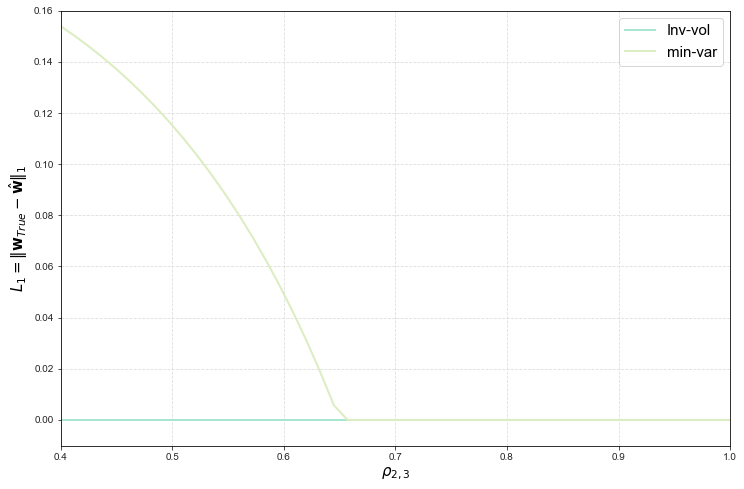

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(rhos, norm_iv_rho, label="Inv-vol")
ax.plot(rhos, norm_gmv_rho, label="min-var")

ax.set_xlabel("$\\rho_{2, 3}$", size=15)
ax.set_ylabel("$L_1 = \\Vert \\mathbf{w}_{True} - \\hat{\\mathbf{w}} \\Vert_1$", size=15)
ax.set_ylim([-0.01, 0.16])
ax.legend();

Minimum variance does not seem affected by overestimation of $\rho_{2, 3}$, but is heavily affected by underestimation (ceteris paribus). 

The inverse volatility portfolio is naturally not affected at all! 

## Problem 2:  Ledoit and Wolf (2003)

In the lectures, we talked about one shrinkage estimator, namely the one suggested by [Ledoit and Wolf (2004), "A well-conditioned estimator for large-dimensional covariance matrices"](https://www.sciencedirect.com/science/article/pii/S0047259X03000964). 

In this problem, we will examine an alternative shrinkage estimator suggested by [Ledoit and Wolf (2003), Improved estimation of the covariance matrix
of stock returns with an application to
portfolio selection](https://www.sciencedirect.com/science/article/abs/pii/S0927539803000070). 

Following the notation in the paper, the sample mean and sample covariance are given by

$$
\mathbf{m}_T = \frac{1}{T}\mathbf{X}\mathbf{1}
$$

and

$$
\mathbf{S}_T = \frac{1}{T}\mathbf{X} \left(\mathbf{I} - \frac{1}{T} \mathbf{1} \mathbf{1}^\top\right) \mathbf{X}^\top
$$

Ledoit and Wolf (2003) notes that since $\mathbf{rank}(\mathbf{AB}) \leq \mathbf{rank}(\mathbf{A})$ then $\mathbf{rank}(\mathbf{S}) \leq \mathbf{rank}\left(\mathbf{I} - \frac{1}{T} \mathbf{1} \mathbf{1}^\top\right) =  T-1$  why we need $N > T-1$ for a non rank-deficient covariance matrix. 

In [14]:
"""
Check 
"""
np.linalg.matrix_rank(np.eye(5) - np.outer(np.ones(5), np.ones(5)) / 5)

4

Ledoit and Wolf (2003) assume that stock returns follow a [single-index model](https://en.wikipedia.org/wiki/Single-index_model)

$$
x_{it} = \alpha_i + \beta_i x_{mt} + \varepsilon_{it}
$$

with $\text{Var}[\varepsilon_{it}] = \delta_{ii}$. The error terms are assumed uncorrelated. 

The covariance matrix is then given by 

$$
\mathbf{\Phi} = \sigma_m^2 \beta \beta^\top + \mathbf{\Delta}
$$

where $\mathbf{\Delta} = \text{diag}(\delta_{11}, ..., \delta_{NN})$. By estimating $\beta_i, i=1,...,N$ by running regressions and obtaining the OLS slope estimate $b_i$ and the residual variance $d_{ii}$, we can estimate the covariance matrix

$$
\mathbf{F} = s_m^2 \mathbf{b} \mathbf{b}^\top + \mathbf{D}
$$

where $\mathbf{D} = \text{diag}(d_{11}, ..., d_{NN})$ and $s_m^2$ is the sample variance of market returns. 

Our problem is that $\mathbf{S}_T$ is unbiased (consistent), but not efficient while $\mathbf{F}$ is not unbiased/consistent, but has smaller variance.  The shrinkage estimator is assumed to take the form 

$$
\mathbf{S}^*  = \alpha \mathbf{F} + (1 - \alpha) \mathbf{S}_T
$$

Thus, the shrinkage intensity will take the form  $\alpha = \kappa / T$ where $\kappa$ is a constant. We notice that the shrinkage vanish asymptotically. The optimal shrinkage constant is found by minimizing the frobenius norm

$$
\Vert \alpha \mathbf{F} + (1 - \alpha) \mathbf{S}_T - \boldsymbol{\Sigma} \Vert
$$

Ledoit and Wolf (2003) show that the optimal shrinkage constant is given by 

$$
\kappa = \frac{\pi - \rho}{\gamma} = \frac{\sum_{i=1}^N\sum_{j=1}^N \pi_{ij} - \sum_{i=1}^N\sum_{j=1}^N \rho_{ij}}{\sum_{i=1}^N\sum_{j=1}^N \gamma_{ij}}
$$

where $\pi_{ij} = \text{AsyVar}[\sqrt{T}s_{ij}]$, $\rho_{ij} = \text{AsyCov}[\sqrt{T} f_{ij}, \sqrt{T} s_{ij}]$  and $\gamma_{ij} = (\phi_{ij} - \sigma_{ij})^2$.

However, these quantities depend on the true, unknown covariance matrix. Ledoit and Wolf (2003) show that a consistent estimator of $\pi_{ij}$  is given by

$$
p_{ij} = \frac{1}{T} \sum \left[(x_{it} - m_i)(x_{jt} - m_j) - s_{ij} \right]^2
$$

A consistent estimator of $\rho_{ij}$ is given by $p_{ij}$ for $i=j$ and for $i \neq j$ then we have $r_{ij} = 1/T \sum_{t=1}^T r_{ijt}$ with 

$$
r_{ijt} = \frac{s_{j,m} s_m (x_{it} - m_i) + s_{i, m} s_m (x_{jt} - m_j) - s_{j,m} s_{i, m} (x_{mt} - m_{mkt})}{s_m^2} (x_{mt} - m_{mkt})(x_{it} - m_i)(x_{jt} - m_j) - f_{ij}s_{ij}
$$

A consistent estimator of $\gamma_{ij}$ is given by $c_{ij} = (f_{ij} - s_{ij})^2$. 


__Question 1__

Define a function implementing the presented shrinkage estimator. 

__Question 2__

We want to simulate data from the model 

$$
r_{it} = \beta_i x_{mt} + \varepsilon_{it}
$$

when assuming $\beta_i \sim \mathcal{U}(-1, 1.5)$ (the $\beta$s follow a uniform distribution), $x_{mt} \sim N(0.05, 0.2^2)$ and $\varepsilon_{it} \sim N(0, 0.05^2)$. 

Simulate data when $T=50, N=100$ and when $T=5000, N=5$. How does the shrinkage estimates compare to the sample covariance matrix in the two cases?

__Question 3__

We define the _percentage relative improvement in average loss_ of $\mathbf{S}^*$ as (we omit $_T$ for simplicity)

$$
\text{PRIAL}(\mathbf{S}^*) = \frac{\text{E}[\Vert \mathbf{S} - \boldsymbol{\Sigma} \Vert]^2 - \text{E}[\Vert \mathbf{S}^* - \boldsymbol{\Sigma} \Vert]^2}{\text{E}[\Vert \mathbf{S} - \boldsymbol{\Sigma} \Vert]^2}
$$

If PRIAL is positive, then the shrinkage estimator performs better than the sample covariance. 

Create a simulation study that compares the PRIAL between the suggested shrinkage estimator and the sample covariance. Consider $T \in \{5, 10, 25, 50, 100, 500\}$ and maintain the assumptions from the previous question. 

### Solution 

__Question 1__

In [15]:
def ledoit_wolf_single_index(returns: np.ndarray, market_return: np.ndarray, demean: bool = True) -> Tuple[np.ndarray, float]:
    """
    Computes the Ledoit and Wolf (2003) shrinkage covariance estimator

    See https://www.sciencedirect.com/science/article/abs/pii/S0927539803000070

    Parameters
    ----------
    returns:
        Num. observations x Num. variables
    market_return:
        Market return, 1-D array
    demean:
        Boolean indicating whether to demean data.

    Returns
    -------
    np.ndarray
        Covariance matrix

    """

    # get dimensions
    T, N = np.shape(returns)

    # demean returns if necessary
    if demean:
        x = returns - np.mean(returns, axis=0)[None, :]
        x_mkt = market_return - np.mean(market_return)
    else:
        x = returns
        x_mkt = market_return

    # sample covariance matrix
    S = x.T @ x / T

    # shrinkage target
    var_mkt = x_mkt @ x_mkt / T
    cov_mkt = x_mkt @ x / T
    beta = cov_mkt / var_mkt
    F = np.outer(beta, beta) * var_mkt
    np.fill_diagonal(F, np.diag(S))

    # shrinkage intensity
    # estimate of pi
    x2 = x ** 2
    p = 1 / T * np.sum(x2.T @ x2) - np.sum(S ** 2)

    # estimate rho
    # diagonal elements
    r_diag = 1 / T * np.sum(x2 ** 2) - sum(np.diag(S) ** 2)

    # off diagonal elements
    z = x * x_mkt[:, None]
    v1 = x2.T @ z / T
    r_off_diag_1 = np.sum(v1 * cov_mkt[None, :]) / var_mkt - np.sum(np.diag(v1) * cov_mkt) / var_mkt

    v2 = z.T @ z / T
    r_off_diag_2 = np.sum(v2 * np.outer(cov_mkt,  cov_mkt)) / var_mkt**2 \
                   - np.sum(np.diag(v2) * cov_mkt**2) / var_mkt**2

    r_off_diag_3 = np.sum(F*S) - np.sum(np.diag(F*S))

    r_off_diag = 2 * r_off_diag_1 - r_off_diag_2 - r_off_diag_3

    r = r_diag + r_off_diag

    # estimate gamma
    c = np.linalg.norm(S - F, "fro") ** 2

    # compute shrinkage constant
    k = (p - r) / c
    alpha = max(0, min(1, k / T))

    # return shrinkage estimator1
    return alpha * F + (1 - alpha) * S, alpha

__Question 2__

In [16]:
T = 100
N = 50

mkt_return = np.random.normal(loc=0.05, scale=0.2, size=T)
betas = np.random.uniform(low=-1, high=1.5, size=N)
returns = mkt_return[:, None] * betas[None, :] + np.random.normal(loc=0, scale=0.05, size=(T, N))

In [17]:
np.cov(returns, rowvar=False)

array([[ 0.03469352, -0.03772593, -0.03660554, ..., -0.02211564,
         0.00669499, -0.04289993],
       [-0.03772593,  0.04638304,  0.04190802, ...,  0.02577808,
        -0.00725527,  0.04994113],
       [-0.03660554,  0.04190802,  0.04301984, ...,  0.02443142,
        -0.00737114,  0.04774543],
       ...,
       [-0.02211564,  0.02577808,  0.02443142, ...,  0.01775463,
        -0.00500626,  0.02939046],
       [ 0.00669499, -0.00725527, -0.00737114, ..., -0.00500626,
         0.00431269, -0.00851932],
       [-0.04289993,  0.04994113,  0.04774543, ...,  0.02939046,
        -0.00851932,  0.0581999 ]])

In [18]:
ledoit_wolf_single_index(returns, mkt_return)

(array([[ 0.03434658, -0.03739699, -0.03589088, ..., -0.02194047,
          0.00649947, -0.04232072],
        [-0.03739699,  0.04591921,  0.04181034, ...,  0.02558636,
         -0.00754731,  0.04934951],
        [-0.03589088,  0.04181034,  0.04258964, ...,  0.02452178,
         -0.00726256,  0.04732031],
        ...,
        [-0.02194047,  0.02558636,  0.02452178, ...,  0.01757708,
         -0.00447214,  0.02895959],
        [ 0.00649947, -0.00754731, -0.00726256, ..., -0.00447214,
          0.00426956, -0.00855666],
        [-0.04232072,  0.04934951,  0.04732031, ...,  0.02895959,
         -0.00855666,  0.0576179 ]]),
 0.9407266165357663)

In [19]:
T = 5000
N = 5

mkt_return = np.random.normal(loc=0.05, scale=0.2, size=T)
betas = np.random.uniform(low=-1, high=1.5, size=N)
returns = mkt_return[:, None] * betas[None, :] + np.random.normal(loc=0, scale=0.05, size=(T, N))

In [20]:
returns.shape

(5000, 5)

In [21]:
np.cov(returns, rowvar=False)

array([[ 0.054708  , -0.02918003,  0.01102906,  0.02055652, -0.02149042],
       [-0.02918003,  0.01878208, -0.00616434, -0.01150311,  0.01206575],
       [ 0.01102906, -0.00616434,  0.00479662,  0.00430483, -0.00451592],
       [ 0.02055652, -0.01150311,  0.00430483,  0.0107522 , -0.00852995],
       [-0.02149042,  0.01206575, -0.00451592, -0.00852995,  0.01154182]])

In [22]:
ledoit_wolf_single_index(returns, mkt_return)

(array([[ 0.05469706, -0.02914474,  0.01102826,  0.02058646, -0.02153374],
        [-0.02914474,  0.01877833, -0.00616257, -0.01150368,  0.01203302],
        [ 0.01102826, -0.00616257,  0.00479566,  0.00435295, -0.00455325],
        [ 0.02058646, -0.01150368,  0.00435295,  0.01075005, -0.00849955],
        [-0.02153374,  0.01203302, -0.00455325, -0.00849955,  0.01153951]]),
 1)

__Question 3__

In [23]:
N = 10
T = 55
num_sim = 10000

# set random seed 
np.random.seed(0)

# true covariance matrix 
sigma_i = 0.01
sigma_m = 0.2
betas = np.random.uniform(low=-1, high=1.5, size=N)
cov_true = np.outer(betas, betas)*sigma_m**2 + np.eye(N) * sigma_i**2

sample_sizes = [5, 10, 25, 50, 100, 500]

prial = list()

for T in sample_sizes:
    loss_sample = list()
    loss_shrinkage = list()
    for i in range(num_sim): 
        
        mkt_returns = np.random.normal(loc=0.05, scale=sigma_m, size=T)
        returns = mkt_returns[:, None] * betas[None, :] + np.random.normal(loc=0,
                                                                           scale=sigma_i,
                                                                           size=(T, N))
        
        mkt_return_test = np.average(returns, axis=1)
        
        sample_cov_mat = np.cov(returns, rowvar=False)
        shrink_cov_mat = ledoit_wolf_single_index(returns, mkt_return_test)[0]

        loss_sample.append(np.linalg.norm(sample_cov_mat - cov_true)) 
        loss_shrinkage.append(np.linalg.norm(shrink_cov_mat - cov_true))
    
    prial_temp =  ((np.mean(loss_sample)**2 / N) - (np.mean(loss_shrinkage)**2 / N)) / (np.mean(loss_sample)**2 / N)
    prial.append(prial_temp)
    
    print("T={}".format(T))
    print("PRIAL: {:.2f}%".format(prial_temp * 100))
    print("\n")

T=5
PRIAL: 15.01%


T=10
PRIAL: 8.13%


T=25
PRIAL: 3.04%


T=50
PRIAL: 1.64%


T=100
PRIAL: 0.70%


T=500
PRIAL: 0.09%




## Problem 3: Simulating the gains of denoising the correlation / covariance matrix 

__Note:__ This problem is heavily inspired [Marcos M. Lopéz de Prado (2020), "Machine Learning for Asset Managers"](https://www.amazon.com/Machine-Learning-Managers-Elements-Quantitative/dp/1108792898)

At the lectures, we discussed how we can use random matrix theory to denoise the correlation matrix. In this problem, we will see the potential benefits  of this approach. 

__Question 1__

In order to perform a relevant simulation study, we need to define a method for defining the true correlation structure that we will use to simulate e.g. returns. 

The following code can generate a random true covariance matrix and mean vector. 

In [24]:
def form_block_corr_matrix(num_blocks: int, block_size: int, block_corr: float) -> np.ndarray: 
    
    """
    Create a block correlation matrix with a number of equal size blocks.
    Each block have the same inter block correlation.
    
    Parameters
    ----------
    num_blocks: 
        Number of blocks
    block_size: 
        Block size. 
    block_corr
        Inter block correlation. 

    Returns
    -------
    np.ndarray
        Correlation matrix.

    """
    
    block = np.ones((block_size, block_size)) * block_corr
    np.fill_diagonal(block, 1.0)
    
    corr_mat = block_diag(*([block] * num_blocks))
    
    return corr_mat 

def form_true_cov_and_mean(num_blocks: int, block_size: int, block_corr: float) -> Tuple[np.ndarray, np.ndarray]:
    
    """
    Creates a covariance matrix and mean vector

    Parameters
    ----------
    num_blocks:
        Number of blocks
    block_size:
        Block size.
    block_corr
        Inter block correlation.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        Covariance matrix, mean vector
    """
    
    # generate corr mat
    corr_mat = form_block_corr_matrix(num_blocks, block_size, block_corr)
    num_assets = corr_mat.shape[0]
    
    idx = np.arange(num_assets)
    np.random.shuffle(idx)
    idx_selector = np.tile(idx.reshape(num_assets, 1), num_assets)
    
    corr_mat = corr_mat[idx_selector, idx_selector.T]
    
    # generate vols
    vols =  np.random.uniform(0.05, 0.2, num_assets)
    
    # generate cov mat
    cov_mat = corr_to_cov_matrix(corr_mat, vols)
    
    # generate means (all assets have same sharpe ratio)
    mu = np.random.normal(vols, vols, size=num_assets)
    
    return mu, cov_mat

Simulate a the true covariance matrix when we have two blocks with five assets. Assume that the block correlation is 0.5. Plot the correlation matrix. 

__Question 2__

Simulate 50 observations from the data generating process specified above (draw 50 observation from a multivariate normal with mean vector and covariance matrix equal to the ones "simulated" above).

Calculate the sample covariance and correlation matrix. 

Plot the empirical correlation matrix. 

__Quesition 3__

We have at the lectures looked at how we can denoise the correlation matrix. We seek to specificy a method to denoise the covariance matrix. Below, we have defined a function to denoise the covariance matrix.  

In [25]:
def denoise_cov_mat(cov_mat: np.ndarray, ratio:float, bandwidth:float=0.01, x_eval=None)->np.ndarray:
    
    """
    Denoises covariance matrix
    
    Parameters
    ----------
    
    cov_mat: 
        Covariance matrix. 
    ratio: 
        Ratio between num. variables and num. obs. 
    bandwidth: 
        Bandwidth for kernel density. 
    x_eval: 
        Values for which to evaluate the pdf. 
        
    Returns
    -------
    np.ndarray
        Denoised covariance matrix. 
    
    """
    
    if x_eval is None:
        x_eval = np.linspace(0.0, 5.0, 10000)
    
    # get corr mat
    corr_mat = cov_to_corr_matrix(cov_mat)
    
    # get eig vals and eig vectors 
    eig_vals, eig_vectors = np.linalg.eigh(corr_mat)
    
    # estimate largest random eigenvalue 
    res = optimize.minimize(fitting_error, 0.25, args=(ratio, x_eval, eig_vals),
                            bounds=((1e-5, 1 - 1e-5),))
    
    var = res.x[0]
    lambda_max = marchencko_pastur_bounds(var, ratio)[-1]
    
    # number of recovered true factors
    num_factors = np.sum(eig_vals > lambda_max)
    
    # make sure that eigenvalues and eigenvectors are sorted
    indices = eig_vals.argsort()[::-1]
    eig_vals_sorted = eig_vals[indices]
    eig_vectors_sorted = eig_vectors[:, indices]
    
    # get denoised corr mat 
    denoised_corr = crem_denoised_corr_mat(eig_vals_sorted, eig_vectors_sorted, num_factors)
    
    # new cov mat                                       
    new_cov_mat = corr_to_cov_matrix(denoised_corr, np.diag(cov_mat) ** 0.5)
    
    return new_cov_mat

Denoise the previously estimated covariance matrix. Plot the denoised correlation matrix. 

__Question 4__

Define a function returning the minimum variance or the maximum Sharpe ratio portfolio given the covariance matrix and in the latter case also the mean vector. 

__Question 5__

We are now ready to perform a simulation study: 

1. Generate a covariance matrix and mean vector when we assume that we have 10 blocks of size 50 with correlation 0.5. 
2. Generate 1000 observations from this model 1000 times. Estimate for each iteration the optimal weights (just minimum variance).
3. Compare the RMSE when using respectively the sample covariance and the denoised covariance (compare with the true minimum variance weights). 

Note that the [Root Mean Squared Error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) is given by 

$$
\text{RMSE} = \sqrt{\text{E}[(\hat{\theta}- \theta])^2}
$$

What approach yields the smallest RMSE?

### Solution 

__Question 1__

We see what we expected. We have constructed a correlation matrix where each asset is correlated with four other assets. 

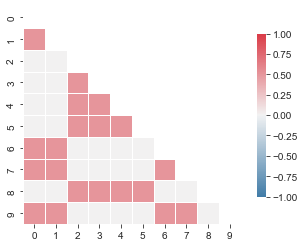

In [26]:
mu_true, cov_mat_true = form_true_cov_and_mean(2, 5, 0.5)
corr_mat_true = cov_to_corr_matrix(cov_mat_true)

correlation_plot(corr_mat_true)

__Question 2__

We see the same structure, but also some randomness!

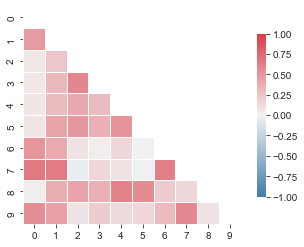

In [27]:
sim_data = np.random.multivariate_normal(mu_true, cov_mat_true, size=50)
cov_mat_est = np.cov(sim_data, rowvar=False)
corr_mat_est = cov_to_corr_matrix(cov_mat_est)

correlation_plot(corr_mat_est)

__Question 3__

In [28]:
cov_mat_denoised = denoise_cov_mat(cov_mat_est, 10 / 50)

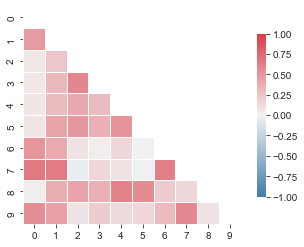

In [29]:
cov_mat_denoised
corr_mat_denoised = cov_to_corr_matrix(cov_mat_denoised)

correlation_plot(corr_mat_est)

__Question 4__

The minimum-variance portfolio is given by 

$$
\begin{align}
\mathbf{w}_{\text{Min-Var}} = \frac{\boldsymbol{\Sigma}^{-1} \mathbf{1}}{\mathbf{1}^\top \boldsymbol{\Sigma}^{-1} \mathbf{1}}
\end{align}
$$

and the tangency portfolio (max Sharpe) is given by 

$$
\mathbf{w}_{\text{Max-Sharpe}} = \frac{\boldsymbol{\Sigma}^{-1}(\boldsymbol{\mu} - r_f \mathbf{1})}{\mathbf{1}^\top \boldsymbol{\Sigma}^{-1}(\boldsymbol{\mu} - r_f \mathbf{1})}
$$

In [30]:
def optimal_portfolio_weights(cov_mat: np.ndarray, mu: np.ndarray=None):
    
    """
    Calculates either the minimum-variance or tangency portfolio. 
    
    Parameters
    ----------
    cov_mat: 
        Covariance matrix of returns
    mu: 
        Expected excess returns. 
    
    Returns
    -------
    np.ndarray
        Optimal portfolio weights. 
    
    """
    
    inv_cov_mat = np.linalg.inv(cov_mat)
    one_vec = np.ones(cov_mat.shape[0])
    
    if mu is None:
        mu = one_vec
        
    opt_w = inv_cov_mat @ mu
    opt_w /= one_vec @ opt_w
    
    return opt_w

__Question 5__

In [31]:
mu_true, cov_mat_true = form_true_cov_and_mean(10, 50, 0.5)
corr_mat_true = cov_to_corr_matrix(cov_mat_true)

true_min_var_weights = optimal_portfolio_weights(cov_mat_true, mu=None)

num_sim = 500
num_obs = 1000

np.random.seed(0)
opt_weights_s = []
opt_weights_d = []

for i in range(num_sim):
    print(i)
    
    sim_data = np.random.multivariate_normal(mu_true, cov_mat_true, size=num_obs)
    cov_mat_est = np.cov(sim_data, rowvar=False)
    corr_mat_est = cov_to_corr_matrix(cov_mat_est)
    mu_est = np.mean(sim_data, axis=0)
    
    cov_mat_denoised = denoise_cov_mat(cov_mat_est, ratio = cov_mat_est.shape[0] / num_obs)
    
    opt_weights_d.append(optimal_portfolio_weights(cov_mat_denoised, mu=None))
    opt_weights_s.append(optimal_portfolio_weights(cov_mat_est, mu=None))
    
opt_weights_d = np.array(opt_weights_d)
opt_weights_s = np.array(opt_weights_s)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


KeyboardInterrupt: 

In [ ]:
"""
RMSE
"""

rmse_s = np.sqrt(np.mean((opt_weights_s - true_min_var_weights)**2))
print(rmse_s)

rmse_d = np.sqrt(np.mean((opt_weights_d - true_min_var_weights)**2))
print(rmse_d)

Clearly, the denoised covariance matrix results in the lowest RMSE!

## Problem 4: The distribution of the covariance matrix with normally distributed variables

Assume that $X_i \sim N(\mu, \sigma^2)$  and consider a random sample of size $T$. Define the sample mean 

$$
\bar{X} = \frac{1}{T} \sum_{i=1}^T X_i
$$

and the sample variance 

$$
S^2 = \frac{1}{T-1} \sum_{i=1}^T (X_i - \bar{X})
$$

We know that 

$$
\bar{X} \sim N(\mu, \sigma^2 / T)
$$

It is possible to show that using the known $\mu$

$$
\frac{\sum_{i=1}^T (X_i - \mu)^2}{\sigma^2} \sim \chi^2 (T)
$$

and when losing one degree of freedom from estimating the mean

$$
\frac{\sum_{i=1}^T (X_i - \bar{X})^2}{\sigma^2} = \frac{(T-1)S^2}{\sigma^2}  \sim \chi^2 (T - 1)
$$

__Question 1__

Assume $\sigma = 0.2$, $\mu = 0$ and $T=10$. Perform a simulation study to check if the distributional assumptions are correct. 

__Question 2__

We could rewrite the above expression such that 

$$
S^2 \sim \frac{\sigma^2}{T-1} C
$$

where $C \sim \chi^2 (T - 1)$. It follows directly that 

$$
\text{E}[S^2] = \frac{\sigma^2}{T-1} (T-1) = \sigma^2
$$

and 

$$
\text{Var}[S^2] = \frac{\sigma^4}{(T-1)^2} 2 (T-1) = \frac{2 \sigma^4}{(T-1)}
$$

What happens when we increase $T$?

__Question 3__

The above can be generalized to the multivariate normal case. If we assume that $\mathbf{X}_i \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})$ follows a multivariate normal then 

$$
T \mathbf{S}_T = \mathbf{Y}^\top \mathbf{Y} \sim W(\boldsymbol{\Sigma}, T)
$$

where $\mathbf{Y}$ is a matrix with demeaned data using the true $\boldsymbol{\mu}$ and $W(\boldsymbol{\Sigma}, T)$ denotes a [Wishart distribution](https://en.wikipedia.org/wiki/Wishart_distribution) with $T$ degrees of freedom. If we use the sample mean to demean, we would have 


$$
(T - 1) \mathbf{S}_T = \mathbf{Y}^\top \mathbf{Y} \sim W(\boldsymbol{\Sigma}, T-1)
$$

Assume 

$$
\mathbf{X}_i \sim N(\mathbf{0}, \boldsymbol{\Sigma})
$$

with $T = 25$ and 

$$
\boldsymbol{\Sigma} =
\begin{bmatrix} 
1.0 & 0.9 &  0.7 \\
0.9 & 1.0 & 0.4 \\
0.7 & 0.4 & 1.0 \end{bmatrix}
$$

Simulate 10000 realizations of sample the covariance matrix and plot the histogram of $\rho_{1,2}$ (sample correlation between the first and second variable). 


__Quesition 4__

Consider the same covariance matrix as in problem 1. Simulate the distribution of the minimum-variance weights. 

### Solution 

__Question 1__

In [32]:
mu = 0.0
sigma = 0.2
num_obs = 10
num_sim = 10000

x_sim = np.random.normal(loc=mu, scale=sigma, size=(num_sim, num_obs))

In [33]:
mu_est = np.mean(x_sim, axis=1)

x_demean_true = x_sim - mu
x_demean_sample = x_sim - mu_est[:, None]

test_stat_true = np.sum(x_demean_true**2 / sigma**2, axis=1)
test_stat_sample = np.sum(x_demean_sample**2 / sigma**2, axis=1)

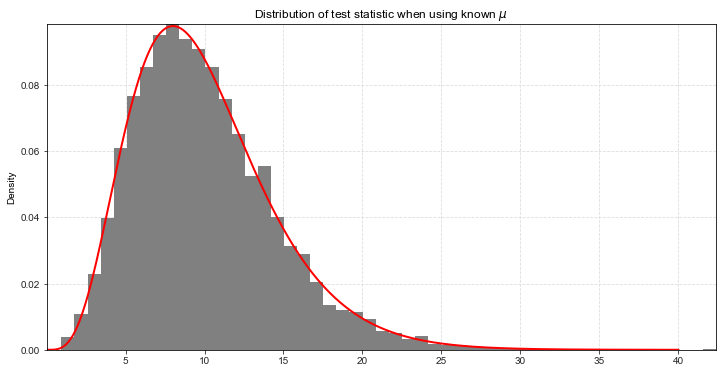

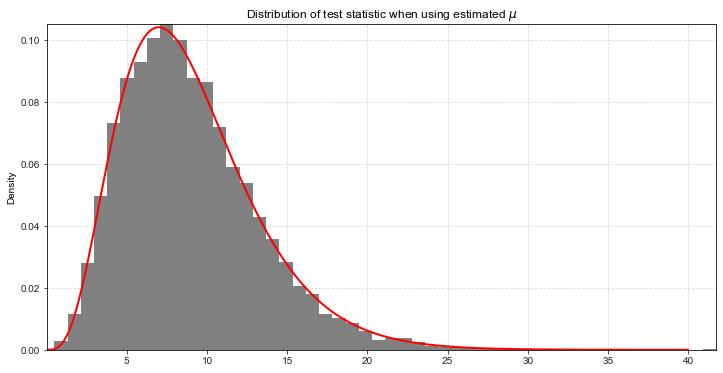

In [34]:
"""
True mu 
"""
values = np.linspace(0.0001, 40, 10000)
pdf_values = stats.chi2.pdf(values, num_obs)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(values, pdf_values, label="True density, dof=10", color="red")
ax.hist(test_stat_true, bins=50,  density=True, color="gray");
ax.set_ylabel("Density");
ax.set_title("Distribution of test statistic when using known $\mu$")

"""
sample mean
"""
values = np.linspace(0.0001, 40, 10000)
pdf_values = stats.chi2.pdf(values, num_obs - 1)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(values, pdf_values, label="True density, dof=9", color="red")
ax.hist(test_stat_sample, bins=50,  density=True, color="gray");
ax.set_ylabel("Density");
ax.set_title("Distribution of test statistic when using estimated $\mu$");

__Question 2__

We see that the distribution collapses around the true value.

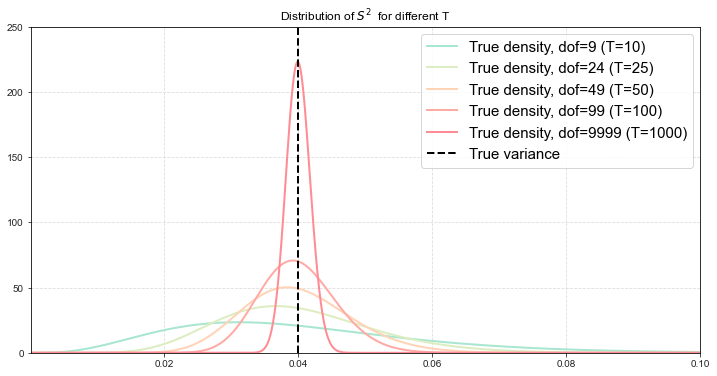

In [35]:
values = np.linspace(0.0001, 0.1, 10000)
pdf_values_10 = stats.chi2.pdf(values, 10 - 1, scale=(sigma**2 /(10 - 1)))
pdf_values_25 = stats.chi2.pdf(values, 25 - 1, scale=(sigma**2 /(25 - 1)))
pdf_values_50 = stats.chi2.pdf(values, 50 - 1, scale=(sigma**2 /(50 - 1)))
pdf_values_100 = stats.chi2.pdf(values, 100 - 1, scale=(sigma**2 /(100 - 1)))
pdf_values_1000 = stats.chi2.pdf(values, 1000 - 1, scale=(sigma**2 /(1000 - 1)))

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(values, pdf_values_10, label="True density, dof=9 (T=10)")
ax.plot(values, pdf_values_25, label="True density, dof=24 (T=25)")
ax.plot(values, pdf_values_50, label="True density, dof=49 (T=50)")
ax.plot(values, pdf_values_100, label="True density, dof=99 (T=100)")
ax.plot(values, pdf_values_1000, label="True density, dof=9999 (T=1000)")
ax.plot([sigma**2, sigma**2], [0.0, 250.0], label="True variance", color="black", linestyle="--")
ax.set_title("Distribution of $S^2$  for different T");
ax.legend();

__Question 3__

In [36]:
T = 25

C = np.array([[1.0, 0.9, 0.7],
              [0.9, 1.0, 0.4],
              [0.7, 0.4, 1.0]])

num_sim = 90000

sim_cov_mat = stats.wishart.rvs(df=T, scale=C, size=num_sim) / T
sim_corr_mat = np.array([cov_to_corr_matrix(sim_cov_mat[i]) for i in range(num_sim)])

Text(0, 0.5, 'Density')

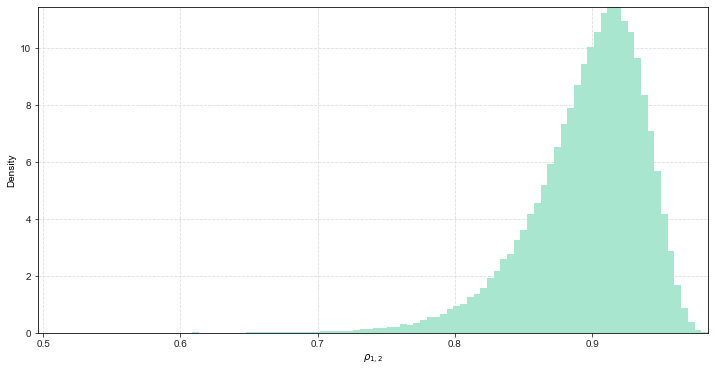

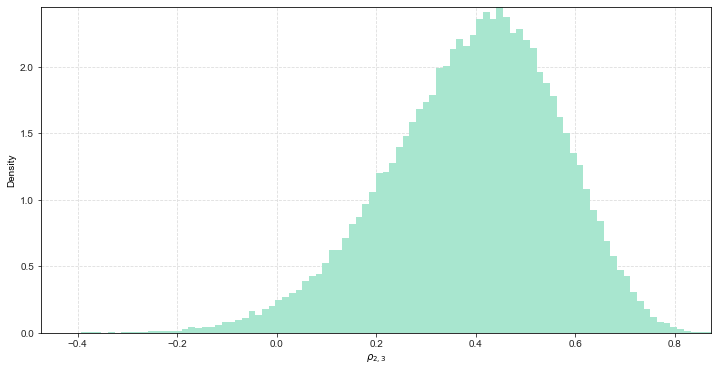

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(sim_corr_mat[:, 0, 1], density=True, bins=100);
ax.set_xlabel("$\\rho_{1, 2}$")
ax.set_ylabel("Density")

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(sim_corr_mat[:, 1, 2], density=True, bins=100);
ax.set_xlabel("$\\rho_{2, 3}$");
ax.set_ylabel("Density")

__Question 4__

In [68]:
# sample lenght
T = 25

# correlations
corr_mat = np.array([[1.0, -0.1, -0.2],
                     [-0.1, 1.0, 0.7],
                     [-0.2, 0.7, 1.0]])
# volatilities
vols = np.array([0.1, 0.1, 0.2])

# calculate covariance matrix 
cov_mat = corr_to_cov_matrix(corr_mat, vols)

# sim covariances
num_sim = 90000
sim_cov_mat = stats.wishart.rvs(df=T, scale=cov_mat, size=num_sim) / T

In [60]:
sim_opt_weights = np.array([optimal_portfolio_weights(sim_cov_mat[i]) for i in range(num_sim)])

In [61]:
w_opt = optimal_portfolio_weights(cov_mat)

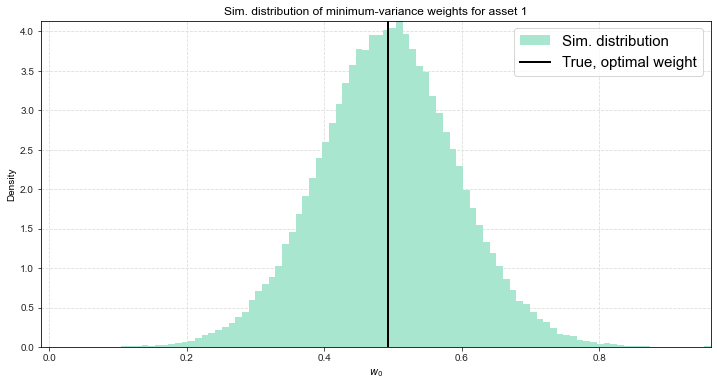

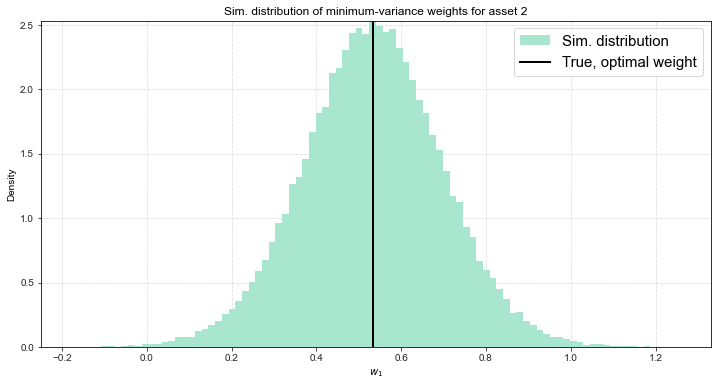

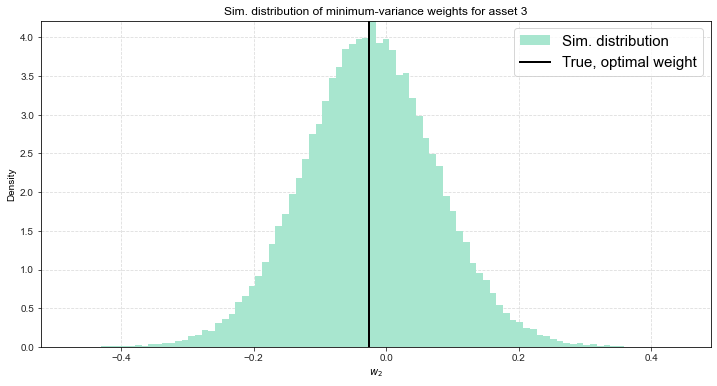

In [67]:
for i in range(len(w_opt)):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hist(sim_opt_weights[:, i], density=True, bins=100, label="Sim. distribution");
    ax.set_xlabel("$w_{}$".format(i))
    ax.axvline(w_opt[i], 0, 1, color="black", label="True, optimal weight")
    ax.set_ylabel("Density")
    ax.set_title('Sim. distribution of minimum-variance weights for asset {}'.format(i + 1))
    ax.legend();


## Problem 5: Time-varying correlation 

We have so far assumed that data was identically and independent distributed when estimating covariance matrices and defining shrinkage estimators. However, in financial markets returns may be uncorrelated but we often find dependence in higher order moments. E.g. financial returns often exhibit volatility clustering. 

__Question 1__

Get adjusted stock prices for Facebook (META), Amazon (AMZN), Apple (AAPL), Netflix (NFLX), and Alphabet (GOOG) from 2013. Calculate daily log returns. 

__Question 2__

We want to specify an exponential filter to estimate the covariance matrix. To that end, we define ($\mathbf{x}_t$ is the return vector at time $t$)

$$
\boldsymbol{\mu}^{\lambda}_{T+1} = \gamma \sum_{t=1}^T e^{-\lambda (T-t)} \mathbf{x}_t
$$

and 

$$
\boldsymbol{\Sigma}^{\lambda}_{T+1} = \gamma \sum_{t=1}^T e^{-\lambda (T-t)} \mathbf{x}_t \mathbf{x}_t^\top  - \boldsymbol{\mu}^{\lambda}_{T+1} (\boldsymbol{\mu}^{\lambda}_{T+1})^\top
$$

where $\gamma = 1 /  \sum_{t=1}^T e^{-\lambda (T-t)}$ to make the weights sum to one. $\lambda$ controls the decay of the exponential filter. A $\lambda=0.0055$ will represent a half-life of approximately six months with daily data. 

Implement the exponential filter and apply it with $\lambda=0.0055$ on the downloaded data set.

__Question 3__

Plot the variance of Facebook. 

Plot the correlation between Facebook and all the other stocks over the time period. 

### Solution

__Quesition 1__

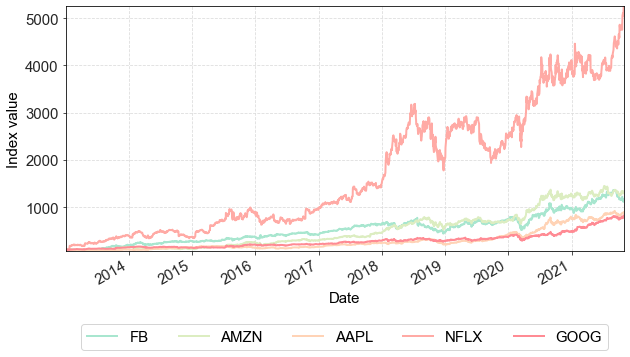

In [544]:
from pandas_datareader.yahoo.daily import YahooDailyReader

"""
Get adjusted stock prices for Facebook (META), Amazon (AMZN), Apple (AAPL), 
Netflix (NFLX), and Alphabet (GOOG).
"""
tickers = ["META", "AMZN", "AAPL", "NFLX", "GOOG"]
faang = YahooDailyReader(tickers, start=datetime.date(2013, 1, 1)).read()

"""
Get adjusted close and normalize
"""
faang_adj_close = faang['Adj Close']
faang_adj_close = faang_adj_close / faang_adj_close.iloc[0, :] * 100

"""
Plot stock prices
"""

ax = faang_adj_close.plot(figsize=(10, 5)); 
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.35), ncol=5); 
ax.set_ylabel('Index value');

In [547]:
faang_adj_log_ret = np.log(faang_adj_close / faang_adj_close.shift(1)).dropna()

__Question 2__

In [654]:
data = faang_adj_log_ret.values

def covariance_exponential_filter(data, decay=0.0055, zero_mean=False): 
    
    data_out = np.einsum('ji,jk->jik', data, data)
    cov_matrices = list()
    mu_est = np.zeros_like(data.shape[1])
    
    for t in np.arange(1, T+1):

        tp = np.arange(0, t)
        weights = np.flip(np.exp(-decay * tp))
        sum_weights = np.sum(weights)
        
        if ~zero_mean:
            mu_est = np.sum(data[:t, :] * weights[:, None], axis=0) / sum_weights
        
        cov_est =   np.sum(data_out[:t, :, :] * weights[:, None, None] / sum_weights, axis=0) - np.outer(mu_est, mu_est)
    
        cov_matrices.append(cov_est)
        
    cov_matrices = np.array(cov_matrices)
    
    return cov_matrices


cov_matrices = covariance_exponential_filter(data, decay=0.0055, zero_mean=True)
corr_matrices = np.array([cov_to_corr_matrix(cov_matrices[i]) for i in range(1, T)])

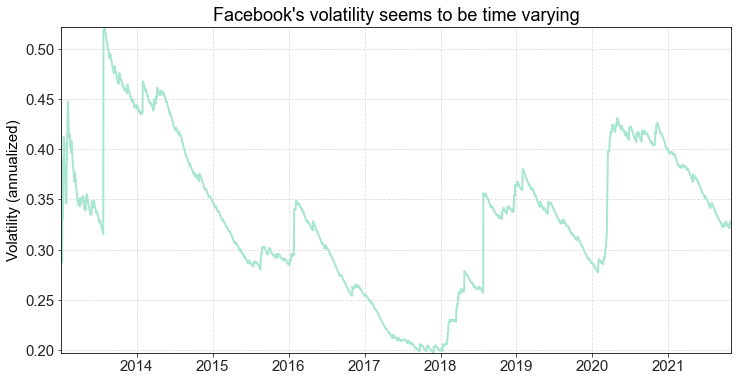

In [655]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(faang_adj_log_ret.index[1:, ], np.sqrt(cov_matrices[1:, 0, 0] * 250));
ax.set_title("Facebook's volatility seems to be time varying");
ax.set_ylabel("Volatility (annualized)");

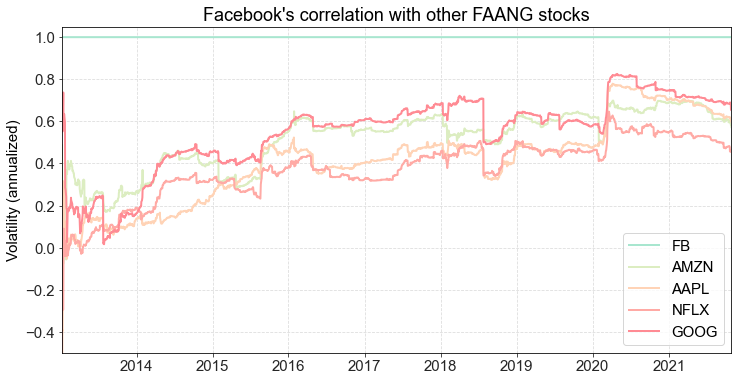

In [656]:
fig, ax = plt.subplots(figsize=(12, 6))
for i in range(5):
    ax.plot(faang_adj_log_ret.index[2:, ], corr_matrices[1:, 0, i], label=tickers[i]);

ax.set_title("Facebook's correlation with other FAANG stocks");
ax.set_ylabel("Volatility (annualized)");
ax.legend()
ax.set_ylim([-0.5, 1.05]);

# References


## Articles

 [Ledoit and Wolf (2003), Improved estimation of the covariance matrix
of stock returns with an application to
portfolio selection](https://www.sciencedirect.com/science/article/abs/pii/S0927539803000070)

[Ardia, Bolliger, Boudt, Fleury (2017), The Impact of Covariance Misspecification in Risk-Based Portfolios](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2650644)

## Books

[Marcos M. Lopéz de Prado (2020), "Machine Learning for Asset Managers"](https://www.amazon.com/Machine-Learning-Managers-Elements-Quantitative/dp/1108792898)